In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split


# Load and preprocess the dataset
file_path = "./Hospital Building Dataset.xlsx"  # Path to your uploaded Excel file
df = pd.read_excel(file_path)

In [3]:
# Focus on the columns needed
df = df[['Date/Time', 'Electricity:Facility [kW](Hourly)']]
df.rename(columns={'Date/Time': 'Timestamp', 'Electricity:Facility [kW](Hourly)': 'Consumption'}, inplace=True)
df['Timestamp'] = '2024 ' + df['Timestamp']
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format=r'%Y %m/%d %H:%M:%S', errors='coerce')

df.head


<bound method NDFrame.head of                Timestamp  Consumption
0    2024-01-01 01:00:00   914.272082
1    2024-01-01 02:00:00   831.588770
2    2024-01-01 03:00:00   847.924133
3    2024-01-01 04:00:00   859.587303
4    2024-01-01 05:00:00   865.348935
...                  ...          ...
8755 2024-12-31 20:00:00  1018.377987
8756 2024-12-31 21:00:00   977.925608
8757 2024-12-31 22:00:00   972.919329
8758 2024-12-31 23:00:00   962.014141
8759 2024-12-31 00:00:00   959.216997

[8760 rows x 2 columns]>

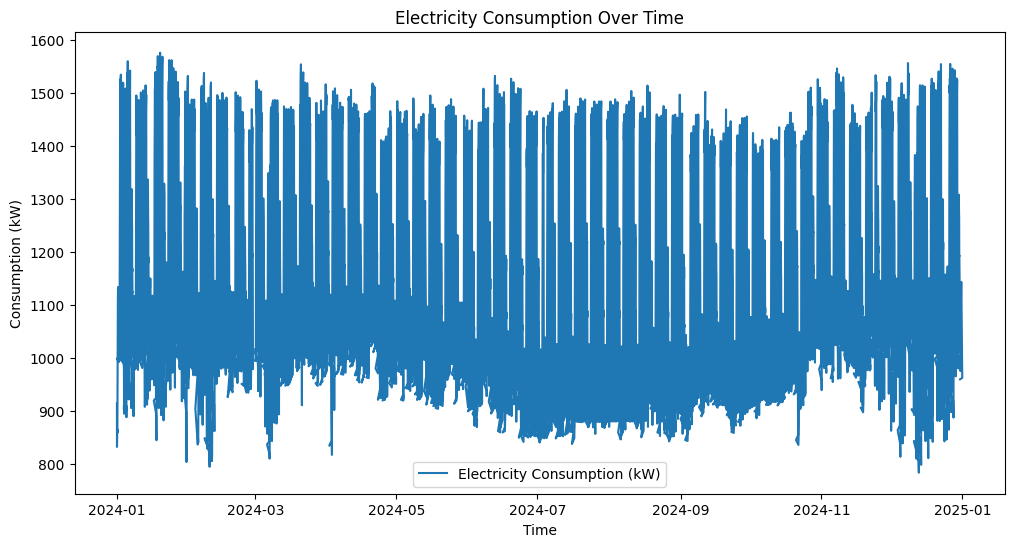

In [4]:
# Drop invalid timestamps and missing values
df.dropna(subset=['Timestamp', 'Consumption'], inplace=True)

# Set the timestamp as the index
df.set_index('Timestamp', inplace=True)

# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Consumption'], label='Electricity Consumption (kW)')
plt.title('Electricity Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Consumption (kW)')
plt.legend()
plt.show()

In [5]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df[['Consumption']])

In [6]:
# Prepare data for LSTM
def create_dataset(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)


In [7]:
X, y = create_dataset(data_scaled, 60)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X

array([[0.16570371, 0.06149472, 0.08208281, ..., 0.90110604, 0.92698815,
        0.92871696],
       [0.06149472, 0.08208281, 0.09678236, ..., 0.92698815, 0.92871696,
        0.87305388],
       [0.08208281, 0.09678236, 0.10404397, ..., 0.92871696, 0.87305388,
        0.91083475],
       ...,
       [0.90577791, 0.92391739, 0.93874435, ..., 0.30129729, 0.29691242,
        0.24592871],
       [0.92391739, 0.93874435, 0.88351305, ..., 0.29691242, 0.24592871,
        0.23961911],
       [0.93874435, 0.88351305, 0.91862511, ..., 0.24592871, 0.23961911,
        0.22587488]])

In [8]:
inputs = tf.keras.Input(shape=(60, 1))
gru_1 = tf.keras.layers.GRU(units=256, return_sequences=True)(inputs)
pool = tf.keras.layers.GlobalMaxPooling1D()(gru_1)
dropout_1 = tf.keras.layers.Dropout(rate=0.2)(pool)
gru_2 = tf.keras.layers.GRU(units=256)(tf.keras.layers.Reshape((-1, 1))(dropout_1))
dense_64 = tf.keras.layers.Dense(units=64, activation='relu')(gru_2)
output = tf.keras.layers.Dense(units=1)(dense_64)
model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error') 
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 60, 256)        │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 256)            │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,337 (1.58 MB)

 Trainable params: 414,337 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32)
print(history.history)


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 77s 335ms/step - loss: 0.0980
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 78s 357ms/step - loss: 0.0672
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 80s 365ms/step - loss: 0.0392
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 82s 378ms/step - loss: 0.0248
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 81s 373ms/step - loss: 0.0124
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 80s 366ms/step - loss: 0.0097
Epoch 7/50
160/218 ━━━━━━━━━━━━━━━━━━━━ 25s 443ms/step - loss: 0.0075

In [ ]:
train_loss = model.evaluate(X_train, y_train, batch_size=32)
print(f'Train Loss: {train_loss}')


218/218 [==============================] - 3s 12ms/step - loss: 0.0012
Train Loss: 0.0011678935261443257


In [1]:
import matplotlib.pyplot as plt
train_predictions = model.predict(X_test)
plt.figure(figsize=(10,6))
plt.plot(y_test[:1000], color='red', label='Actual')  
plt.plot(train_predictions[:1000], color='blue', label='Prediction')  
plt.xlabel('Time Step')
plt.ylabel('Electricity Consumption (kW)')
plt.legend()
plt.title('Actual vs Predicted (Test Data) - Subset')
plt.show()



NameError: name 'model' is not defined